In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os
import cv2
from radiomics.imageoperations import resegmentMask

In [29]:
def segmentation(stack, rows,cols, Hues_params, tma, grid, gaussian=[0,0],fine_segmentation=False,erode_kernel=0,plots=False,center='Zürich'):
    
    """
    stack: the image to be segmented
    row, cols: number of rows and columns in the image
    Hues_params: a dictionary containing hue parameteres with their name as the keys and values as the dict values.
    tma: the name of tma, saved in the segmentation_mapping.csv for reference purposes
    grid: name of the tma grids, saved in the segmentation_mapping.csv for reference purposes
    gaussian: if non zero it is the gaussian kernel size used on the image
    fine_segmentation: if set to true it does perform a air inclusion and embedding artifact exclusion from the generated masks.
    erode_kernel: kernel size of the erosion of the mask, larger values ensures artifacts are exluded, but less sample remains for feature calculation. A safe value is 2.
    plots: if set to true, it returns a plot of the segmentation steps.
    center: if set to other than Zürich, then the coordinates in the segmentation mask are x: west to east, y: north to south.
            if set to Zürich, the coordinates are x: south to north, y: west to east. 
            you can achieve any other coordinates by using rotation transforms.
    """
        
    # stack has to be SimpleITK object
    stack = sitk.GetArrayFromImage(stack)
    if center=='Zürich':
        stack = np.rot90(stack,k=3,axes=(1,2)) # for transforming coordinates to Zürich ngTMAs
    radius = Hues_params.get('radius')
    # Z-projection for easier and more reliable processing
    img = np.average(stack,axis=0)*100
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    #img = np.rot90(img)
        
    if gaussian != [0,0]:
        img = cv2.GaussianBlur(img,gaussian,0)
            
    cimg = np.array(img)
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,2,Hues_params.get('minDist'),param1=Hues_params.get('param1'),
                                  param2=Hues_params.get('param2'),minRadius=radius,maxRadius=radius)
    circles = circles.squeeze()
    circles[:,[1,0]]=circles[:,[0,1]]
    circles = np.uint16(circles)
    FlatMask = np.uint16(np.zeros(img.shape))

    yind = np.digitize(circles[:,0],np.histogram_bin_edges(circles[:,0],bins=rows,range=(0,img.shape[0])))
    xind = np.digitize(circles[:,1],np.histogram_bin_edges(circles[:,1],bins=cols,range=(0,img.shape[1])))
    indices = np.column_stack((yind,xind))
    temp = np.lexsort((indices[:,1],indices[:,0]),axis=0)
    circles = circles[temp,:]
    indices = indices[temp,:]
    mapping = pd.DataFrame()
    dictionary = {}
    gray_val = 0
        
    for i in range(circles.shape[0]):
        gray_val += 1
        # draw the mask
        cv2.circle(FlatMask,(circles[i,1],circles[i,0]),circles[i,2],gray_val,-1)
        # draw the outer line of the circle
        cv2.circle(cimg,(circles[i,1],circles[i,0]),circles[i,2],255,2)
        # draw the center of the circle
        cv2.circle(cimg,(circles[i,1],circles[i,0]),circles[i,2],255,3)
        dictionary.update({'x':indices[i,1],'y':indices[i,0],'Gray value':gray_val})
        mapping = pd.concat([mapping, pd.DataFrame([dictionary])],ignore_index=True)
        
    mapping.insert(0,'TMA',tma)
    mapping.insert(1,'Grid',grid)
    mapping.to_csv('segmentation_mapping.csv')
    mask = np.uint16(np.zeros(stack.shape))

    for i in range(stack.shape[0]):
        mask[i,:,:] = FlatMask

    binary = np.uint8(np.array(mask))
    binary[binary>=1] = 1
        
    # Morphological operations on the mask
    
    if fine_segmentation == True:
        binary = sitk.GetImageFromArray(binary)
        stack = sitk.GetImageFromArray(stack)
            
        binary = resegmentMask(stack,binary,resegmentRange=[1,255], label=1)
        
        if erode_kernel != 0:
            Erode_filter = sitk.BinaryErodeImageFilter()
            Erode_filter.SetKernelRadius(erode_kernel)
            Erode_filter.SetKernelType(sitk.sitkBall)
            Erode_filter.SetForegroundValue(1)
            binary = Erode_filter.Execute(binary)
                
        binary = sitk.GetArrayFromImage(binary)
        stack = sitk.GetArrayFromImage(stack)
        
    mask = binary*mask
            
    # Visualizing Results
    if plots == True:
        fig, ax = plt.subplots(1,5,figsize=(16,9))
            
        ax[0].imshow(stack[0],cmap='gray')
        ax[0].title.set_text('Image')
        ax[0].axis('off')
            
        ax[1].imshow(cimg,cmap='gray')
        ax[1].title.set_text('Circles')
        ax[1].axis('off')
            
        ax[2].imshow(binary[0],cmap='gray')
        ax[2].title.set_text('Binary mask')
        ax[2].axis('off')
            
        ax[3].imshow(mask[0],cmap='gray')
        ax[3].title.set_text('Coordinated mask')
        ax[3].axis('off')
            
        ax[4].imshow((binary*stack)[0],cmap='gray')
        ax[4].title.set_text('Segmented Image')
        ax[4].axis('off')
        
    if center=='Zürich':
        mask = np.rot90(mask,k=1,axes=(1,2)) # for transforming mask back to original image orientation after transforming axis to Zürich ngTMAs
        
    mask = sitk.GetImageFromArray(mask)
    mask.SetSpacing((1.0, 1.0, 1.0))  # Ensure proper spacing
    mask.SetOrigin((0.0, 0.0, 0.0))   # Set origin
    writer = sitk.ImageFileWriter()
    writer.SetFileName('mask.tif')
    writer.UseCompressionOff()
    writer.Execute(sitk.Cast(mask,sitk.sitkUInt16))
        
    return mask, circles, mapping, fig

In [27]:
name = "H64(B)" # name of the TMA
os.chdir(f"...\\{name}") # path to the TMA
stack = sitk.ReadImage(f"{name}.tif")
Hues_params = {'radius':65, 'minDist' : 130,'param1' : 20,'param2' : 20} # Hues parameters
gaussian = [9,9] # Gaussian kernel
multiply = sitk.MultiplyImageFilter()

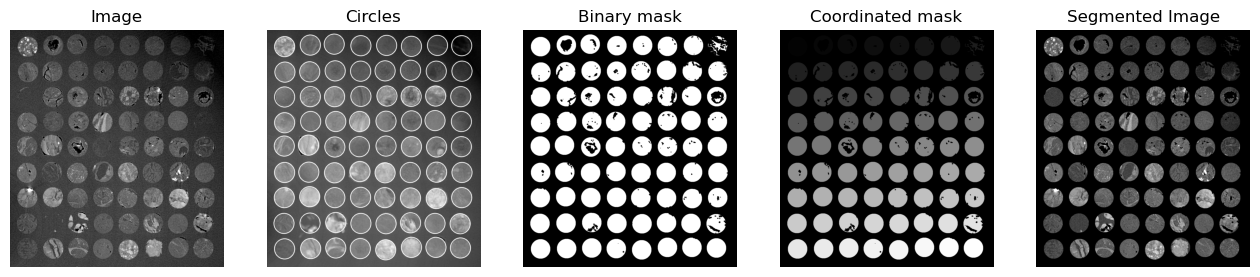

In [28]:
mask, circ, mapping, fig = segmentation(stack, 9,8,Hues_params, tma='H64',grid='B', gaussian=gaussian, fine_segmentation=True, erode_kernel=2, plots=True, center='Zürich')
fig.savefig('segmentation steps.png',dpi=400)